In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
from dateutil.relativedelta import relativedelta

In [2]:
x = dt.date(2012, 10, 2) 
x = x + relativedelta(years=1)
x

datetime.date(2013, 10, 2)

In [52]:
def schedule_from_grant(shares, start_date, cliff, vesting, vesting_frequency):
    unvested = shares
    vested = 0
    
    dates = pd.date_range(start_date + relativedelta(years=cliff), start_date + relativedelta(years=cliff, months=vesting), freq=vesting_frequency)
    schedule = pd.DataFrame({"vested": np.zeros(len(dates)), "unvested": np.zeros(len(dates))}, index=dates, dtype=int)
    for date in dates:
        to_vest = min(round(shares / len(dates)), unvested)
        unvested -= to_vest
        vested += to_vest
        schedule.loc[date] = [vested, unvested]
    
    
    return schedule.vested
    

def get_value_at_date(schedule, date, stock_price, strike_price=None):
    vested_at_date = schedule.resample("1D").ffill().loc[date]
    return vested_at_date  * max(stock_price - strike_price, 0)

def stock_price_from_valuation(valuation_in_billions):
    return valuation_in_billions / 10.0 * 13.37

[56.05407229 96.21667075] 75.0 12.24744871391589


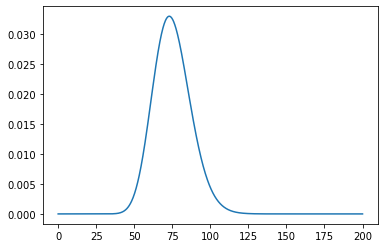

In [53]:
target_mean = 75.0
target_scale = 2.0

valuation_dist = stats.gamma(target_mean / target_scale, scale=target_scale)

xs = np.linspace(0, 200, 1000)
ps = valuation_dist.pdf(xs)
pd.Series(ps, index=xs).plot()

print(
    valuation_dist.ppf([0.05, 0.95]),
    valuation_dist.mean(),
    valuation_dist.std()
)

In [59]:
    get_value_at_date(
        schedule_from_grant(grant["shares"], grant["start_date"], grant["cliff"], grant["vesting"], grant["vesting_frequency"]),
        dt.date(2022, 12, 31),
        30,
        grant["strike"]
    )

NameError: name 'grant' is not defined

In [62]:
grants = [
    {"shares":  2131, "start_date": dt.date(2021,  3, 2), "cliff": 0, "vesting": 36, "vesting_frequency": "3M", "strike": 0},
    {"shares": 11250, "start_date": dt.date(2019, 12, 2), "cliff": 1, "vesting": 48, "vesting_frequency": "1M", "strike": 6.698},
]

[
    get_value_at_date(
        schedule_from_grant(grant["shares"], grant["start_date"], grant["cliff"], grant["vesting"], grant["vesting_frequency"]),
        dt.date(2022, 12, 1),
        30,
        grant["strike"]
    )
    for grant in grants
]

KeyError: datetime.date(2022, 12, 1)

In [33]:
values = pd.Series([
    get_value_at_date(schedule, "2021-12-01", stock_price_from_valuation(valuation), 0.0)
    for valuation in valuation_dist.rvs(10000)
])

<AxesSubplot:>

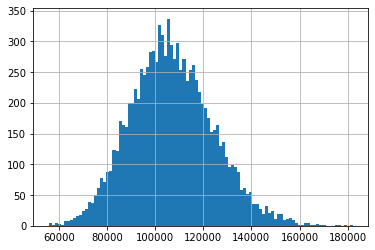

In [34]:
values.hist(bins=100)